# Speech Emotion Recognition using CNNs

## AI Club - Round 2 Technical Task

**Objective**: Build a CNN model to classify 8 emotions from speech audio

**Author**: Manan Farkya

---

## Table of Contents

1. [Setup & Imports](#1.-Setup-&-Imports)
2. [Data Loading & Exploration](#2.-Data-Loading-&-Exploration)
3. [Audio Preprocessing & EDA](#3.-Audio-Preprocessing-&-EDA)
4. [Feature Engineering](#4.-Feature-Engineering)
5. [Data Augmentation](#5.-Data-Augmentation)
6. [Model Architecture](#6.-Model-Architecture)
7. [Training](#7.-Training)
8. [Evaluation & Analysis](#8.-Evaluation-&-Analysis)
9. [Conclusion](#9.-Conclusion)

---
## 1. Setup & Imports

In [37]:
# Core libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Audio processing
import librosa
import librosa.display

# Deep learning 
import tensorflow as tf
import keras
from keras import layers, models

# Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"Librosa version: {librosa.__version__}")

TensorFlow version: 2.16.1
Keras version: 3.0.5
Librosa version: 0.10.1


In [38]:
# Import project modules
import config
from preprocessing import *
from model import *

# Set random seeds
np.random.seed(config.RANDOM_SEED)
tf.random.set_seed(config.RANDOM_SEED)

print("Project modules loaded successfully!")

Project modules loaded successfully!


---
## 2. Data Loading & Exploration

### RAVDESS Dataset Structure

**Filename format**: `Modality-VocalChannel-Emotion-Intensity-Statement-Repetition-Actor.wav`

Example: `03-01-05-02-01-01-12.wav`

- **Modality**: 01 = full-AV, 02 = video-only, 03 = audio-only
- **Vocal channel**: 01 = speech, 02 = song
- **Emotion**: 01-08 (neutral, calm, happy, sad, angry, fearful, disgust, surprised)
- **Emotional intensity**: 01 = normal, 02 = strong
- **Statement**: 01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door"
- **Repetition**: 01 = 1st repetition, 02 = 2nd repetition
- **Actor**: 01-24 (odd = male, even = female)

In [39]:
# Find all audio files in dataset
audio_files = []
for root, dirs, files in os.walk(config.DATA_DIR):
    for file in files:
        if file.endswith('.wav'):
            audio_files.append(os.path.join(root, file))

print(f"Total audio files found: {len(audio_files)}")
print(f"\nSample filenames:")
for file in audio_files[:5]:
    print(f"  {os.path.basename(file)}")

Total audio files found: 1440

Sample filenames:
  03-01-01-01-01-01-01.wav
  03-01-01-01-01-02-01.wav
  03-01-01-01-02-01-01.wav
  03-01-01-01-02-02-01.wav
  03-01-02-01-01-01-01.wav


In [40]:
# Extract metadata from filenames
metadata = []

for file_path in audio_files:
    filename = os.path.basename(file_path)
    parts = filename.split('-')
    
    if len(parts) >= 7:
        emotion = extract_emotion_from_filename(file_path)
        gender = extract_gender_from_filename(file_path)
        
        metadata.append({
            'filename': filename,
            'path': file_path,
            'emotion': emotion,
            'gender': gender,
            'intensity': parts[3],
            'actor': int(parts[6].split('.')[0])
        })

df = pd.DataFrame(metadata)
print(f"Dataset shape: {df.shape}")
df.head(10)

Dataset shape: (1440, 6)


,filename,path,emotion,gender,intensity,actor
0,03-01-01-01-01-01-01.wav,C:\Users\manan_4lx8ye\Desktop\aiclubb\data\RAV...,neutral,male,01,1
1,03-01-01-01-01-02-01.wav,C:\Users\manan_4lx8ye\Desktop\aiclubb\data\RAV...,neutral,male,01,1
2,03-01-01-01-02-01-01.wav,C:\Users\manan_4lx8ye\Desktop\aiclubb\data\RAV...,neutral,male,01,1
3,03-01-01-01-02-02-01.wav,C:\Users\manan_4lx8ye\Desktop\aiclubb\data\RAV...,neutral,male,01,1
4,03-01-02-01-01-01-01.wav,C:\Users\manan_4lx8ye\Desktop\aiclubb\data\RAV...,calm,male,01,1
5,03-01-02-01-01-02-01.wav,C:\Users\manan_4lx8ye\Desktop\aiclubb\data\RAV...,calm,male,01,1
6,03-01-02-01-02-01-01.wav,C:\Users\manan_4lx8ye\Desktop\aiclubb\data\RAV...,calm,male,01,1
7,03-01-02-01-02-02-01.wav,C:\Users\manan_4lx8ye\Desktop\aiclubb\data\RAV...,calm,male,01,1
8,03-01-02-02-01-01-01.wav,C:\Users\manan_4lx8ye\Desktop\aiclubb\data\RAV...,calm,male,02,1
9,03-01-02-02-01-02-01.wav,C:\Users\manan_4lx8ye\Desktop\aiclubb\data\RAV...,calm,male,02,1


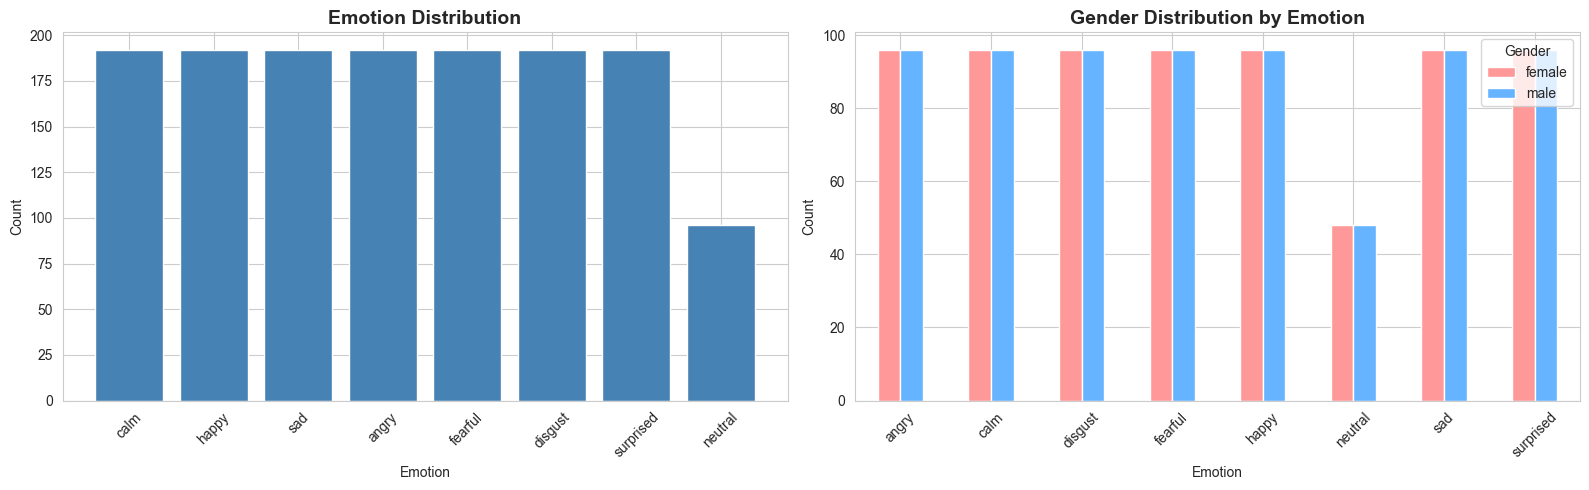


Dataset Statistics:
  Total samples: 1440
  Number of emotions: 8
  Male speakers: 720
  Female speakers: 720


In [41]:
# Emotion distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Emotion counts
emotion_counts = df['emotion'].value_counts()
axes[0].bar(emotion_counts.index, emotion_counts.values, color='steelblue')
axes[0].set_title('Emotion Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Emotion')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Gender distribution per emotion
gender_emotion = df.groupby(['emotion', 'gender']).size().unstack()
gender_emotion.plot(kind='bar', ax=axes[1], color=['#ff9999', '#66b3ff'])
axes[1].set_title('Gender Distribution by Emotion', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Emotion')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Gender')

plt.tight_layout()
plt.show()

print("\nDataset Statistics:")
print(f"  Total samples: {len(df)}")
print(f"  Number of emotions: {df['emotion'].nunique()}")
print(f"  Male speakers: {(df['gender'] == 'male').sum()}")
print(f"  Female speakers: {(df['gender'] == 'female').sum()}")

---
## 3. Audio Preprocessing & EDA

### Visualizing Raw Audio Waveforms

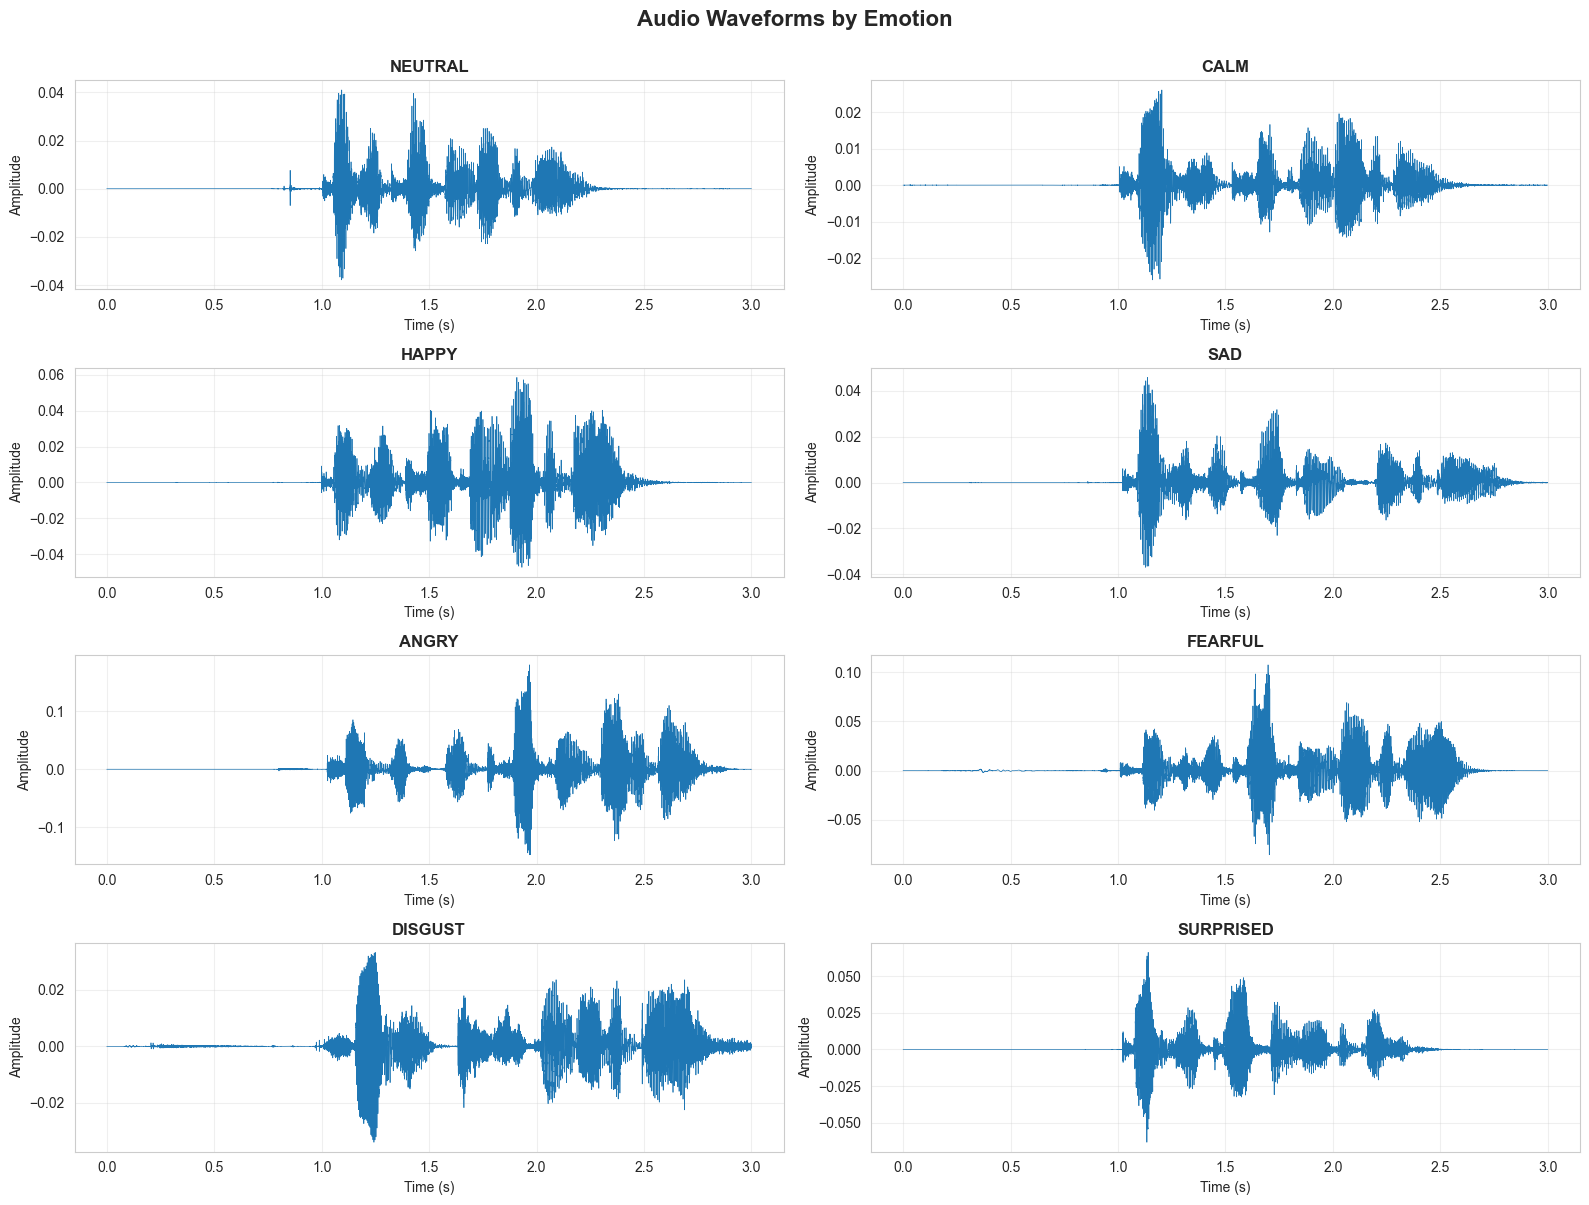

In [42]:
# Visualize waveforms for different emotions
fig, axes = plt.subplots(4, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, emotion in enumerate(config.EMOTIONS):
    # Get sample file for this emotion
    sample_file = df[df['emotion'] == emotion].iloc[0]['path']
    
    # Load audio
    audio = load_audio(sample_file)
    
    # Plot waveform
    time = np.linspace(0, config.DURATION, len(audio))
    axes[idx].plot(time, audio, linewidth=0.5)
    axes[idx].set_title(f'{emotion.upper()}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Time (s)')
    axes[idx].set_ylabel('Amplitude')
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Audio Waveforms by Emotion', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### Mel-Spectrogram Visualization

**Key Observation**: High-arousal emotions (e.g., Angry) show more intense spectral energy compared to low-arousal emotions (e.g., Sad, Calm)

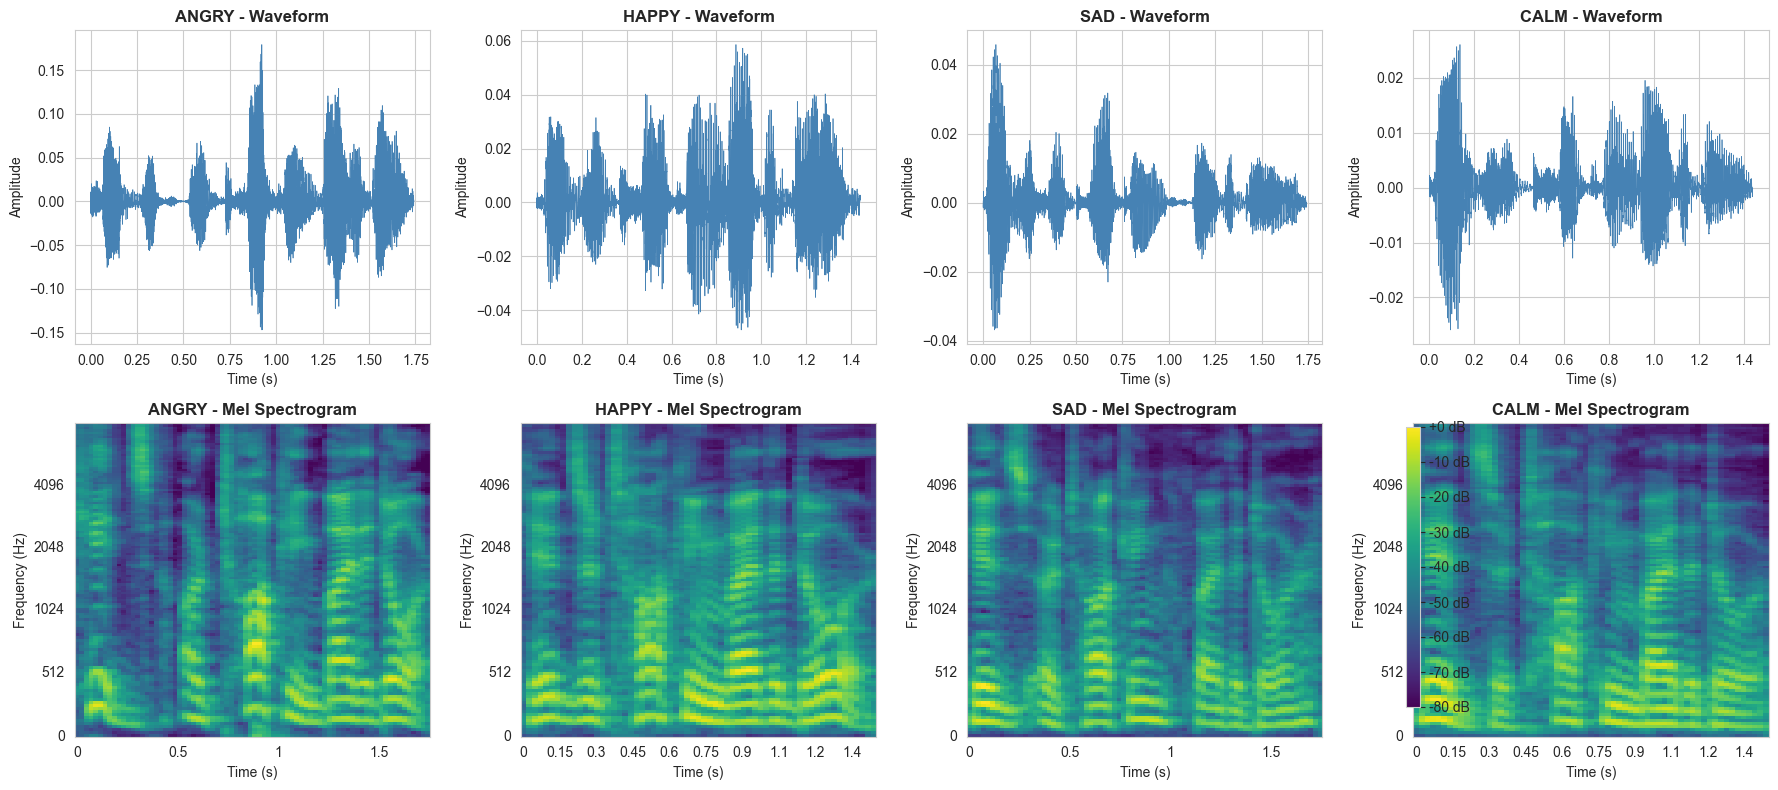

In [43]:
# Compare spectrograms: High arousal (Angry) vs Low arousal (Sad)
fig, axes = plt.subplots(2, 4, figsize=(18, 8))

comparison_emotions = ['angry', 'happy', 'sad', 'calm']

for idx, emotion in enumerate(comparison_emotions):
    # Get sample file
    sample_file = df[df['emotion'] == emotion].iloc[0]['path']
    
    # Load and process
    audio = load_audio(sample_file)
    audio_trimmed = trim_silence(audio)
    
    # Extract mel spectrogram
    mel_spec = extract_mel_spectrogram(audio_trimmed)
    
    # Plot waveform
    time = np.linspace(0, len(audio_trimmed)/config.SAMPLE_RATE, len(audio_trimmed))
    axes[0, idx].plot(time, audio_trimmed, linewidth=0.5, color='steelblue')
    axes[0, idx].set_title(f'{emotion.upper()} - Waveform', fontweight='bold')
    axes[0, idx].set_xlabel('Time (s)')
    axes[0, idx].set_ylabel('Amplitude')
    
    # Plot spectrogram
    img = librosa.display.specshow(mel_spec, x_axis='time', y_axis='mel',
                                   sr=config.SAMPLE_RATE, fmax=config.FMAX,
                                   ax=axes[1, idx], cmap='viridis')
    axes[1, idx].set_title(f'{emotion.upper()} - Mel Spectrogram', fontweight='bold')
    axes[1, idx].set_xlabel('Time (s)')
    axes[1, idx].set_ylabel('Frequency (Hz)')

plt.colorbar(img, ax=axes[1, :], format='%+2.0f dB')
plt.tight_layout()
plt.show()

---
## 4. Feature Engineering

Converting audio to Log-Mel Spectrograms for CNN input

Processing: 03-01-01-01-01-01-01.wav
1. Raw audio shape: (66150,)
2. After trimming: (27136,)
3. Mel spectrogram shape: (128, 54)
4. Resized spectrogram: (128, 128)


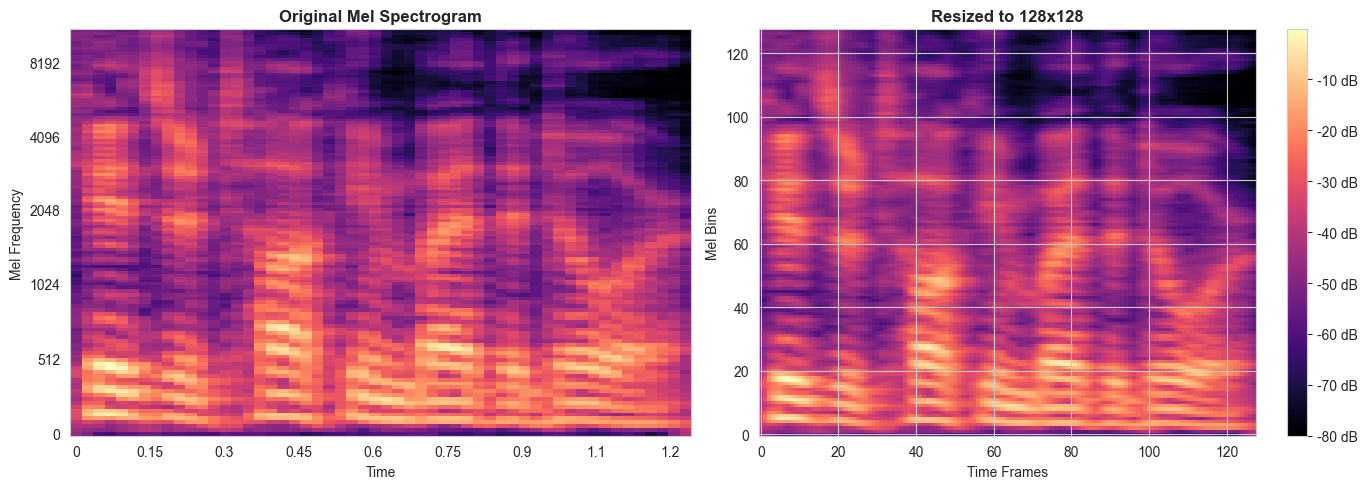

In [44]:
# Visualize the complete preprocessing pipeline
sample_file = audio_files[0]
print(f"Processing: {os.path.basename(sample_file)}")

# Step 1: Load
audio_raw = load_audio(sample_file)
print(f"1. Raw audio shape: {audio_raw.shape}")

# Step 2: Trim silence
audio_trimmed = trim_silence(audio_raw)
print(f"2. After trimming: {audio_trimmed.shape}")

# Step 3: Extract mel spectrogram
mel_spec = extract_mel_spectrogram(audio_trimmed)
print(f"3. Mel spectrogram shape: {mel_spec.shape}")

# Step 4: Resize
mel_spec_resized = resize_spectrogram(mel_spec)
print(f"4. Resized spectrogram: {mel_spec_resized.shape}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

librosa.display.specshow(mel_spec, x_axis='time', y_axis='mel',
                        sr=config.SAMPLE_RATE, ax=axes[0], cmap='magma')
axes[0].set_title('Original Mel Spectrogram', fontweight='bold')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Mel Frequency')

im = axes[1].imshow(mel_spec_resized, aspect='auto', origin='lower', cmap='magma')
axes[1].set_title(f'Resized to {config.IMG_HEIGHT}x{config.IMG_WIDTH}', fontweight='bold')
axes[1].set_xlabel('Time Frames')
axes[1].set_ylabel('Mel Bins')

plt.colorbar(im, ax=axes[1], format='%+2.0f dB')
plt.tight_layout()
plt.show()

---
## 5. Data Augmentation

To prevent overfitting and help the model generalize across different voices

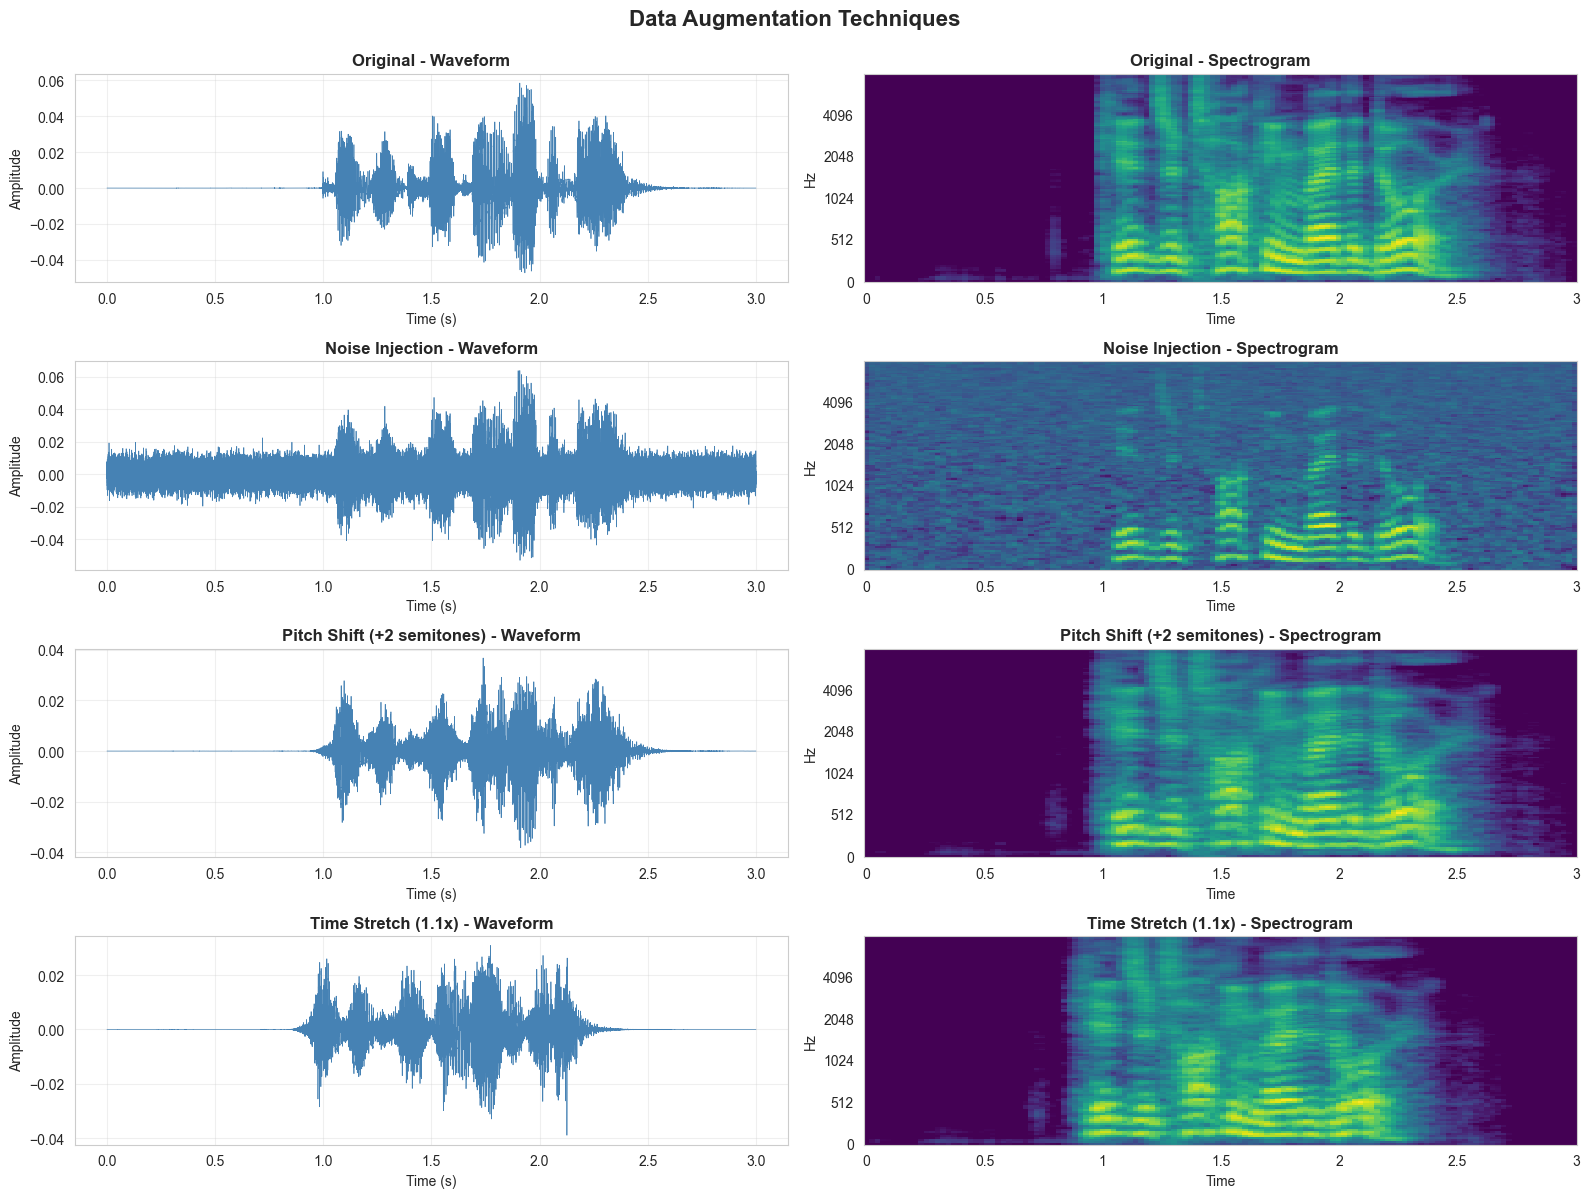

In [45]:
# Demonstrate data augmentation techniques
sample_file = df[df['emotion'] == 'happy'].iloc[0]['path']
audio_original = load_audio(sample_file)

# Apply augmentations
audio_noisy = add_noise(audio_original)
audio_pitched = pitch_shift(audio_original, n_steps=2)
audio_stretched = time_stretch(audio_original, rate=1.1)

# Pad stretched audio to same length
if len(audio_stretched) < len(audio_original):
    audio_stretched = np.pad(audio_stretched, 
                            (0, len(audio_original) - len(audio_stretched)))
else:
    audio_stretched = audio_stretched[:len(audio_original)]

# Plot all versions
fig, axes = plt.subplots(4, 2, figsize=(16, 12))

augmentations = [
    (audio_original, 'Original'),
    (audio_noisy, 'Noise Injection'),
    (audio_pitched, 'Pitch Shift (+2 semitones)'),
    (audio_stretched, 'Time Stretch (1.1x)')
]

time = np.linspace(0, config.DURATION, len(audio_original))

for idx, (audio, label) in enumerate(augmentations):
    # Waveform
    axes[idx, 0].plot(time, audio, linewidth=0.5, color='steelblue')
    axes[idx, 0].set_title(f'{label} - Waveform', fontweight='bold')
    axes[idx, 0].set_xlabel('Time (s)')
    axes[idx, 0].set_ylabel('Amplitude')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Spectrogram
    mel_spec = extract_mel_spectrogram(audio)
    librosa.display.specshow(mel_spec, x_axis='time', y_axis='mel',
                            sr=config.SAMPLE_RATE, fmax=config.FMAX,
                            ax=axes[idx, 1], cmap='viridis')
    axes[idx, 1].set_title(f'{label} - Spectrogram', fontweight='bold')

plt.suptitle('Data Augmentation Techniques', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

---
## 6. Model Architecture

2D CNN with:
- 4 Convolutional Blocks
- Batch Normalization
- MaxPooling
- Dropout
- Global Average Pooling

In [46]:
# Create and display model architecture
model = create_model()
model.summary()

print(f"\nTotal parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 32, 32, 256)    │             

 Total params: 4,858,696 (18.53 MB)

 Trainable params: 4,854,088 (18.52 MB)

 Non-trainable params: 4,608 (18.00 KB)


Total parameters: 4,858,696
Trainable parameters: 4,854,088


In [47]:
# Visualize model architecture
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, 
                      rankdir='TB', dpi=100)

You must install pydot (`pip install pydot`) for `plot_model` to work.


---
## 7. Training

### Load and Prepare Dataset

In [48]:
# Load dataset
print("Loading RAVDESS dataset...")
X_train, X_val, X_test, y_train, y_val, y_test = load_dataset(
    data_dir=config.DATA_DIR,
    augment_train=False,  # Set to True for better results
    test_size=config.TEST_SPLIT,
    val_size=config.VALIDATION_SPLIT
)

print(f"\nDataset shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val: {X_val.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  y_val: {y_val.shape}")
print(f"  y_test: {y_test.shape}")

Loading RAVDESS dataset...
Loading RAVDESS dataset...
Found 1440 audio files


Processing audio files: 100%|██████████| 1440/1440 [00:21<00:00, 65.86it/s]


Dataset shape: (1440, 128, 128, 1)
Labels shape: (1440,)
Train: (1152, 128, 128, 1), Val: (144, 128, 128, 1), Test: (144, 128, 128, 1)

Dataset shapes:
  X_train: (1152, 128, 128, 1)
  X_val: (144, 128, 128, 1)
  X_test: (144, 128, 128, 1)
  y_train: (1152, 8)
  y_val: (144, 8)
  y_test: (144, 8)


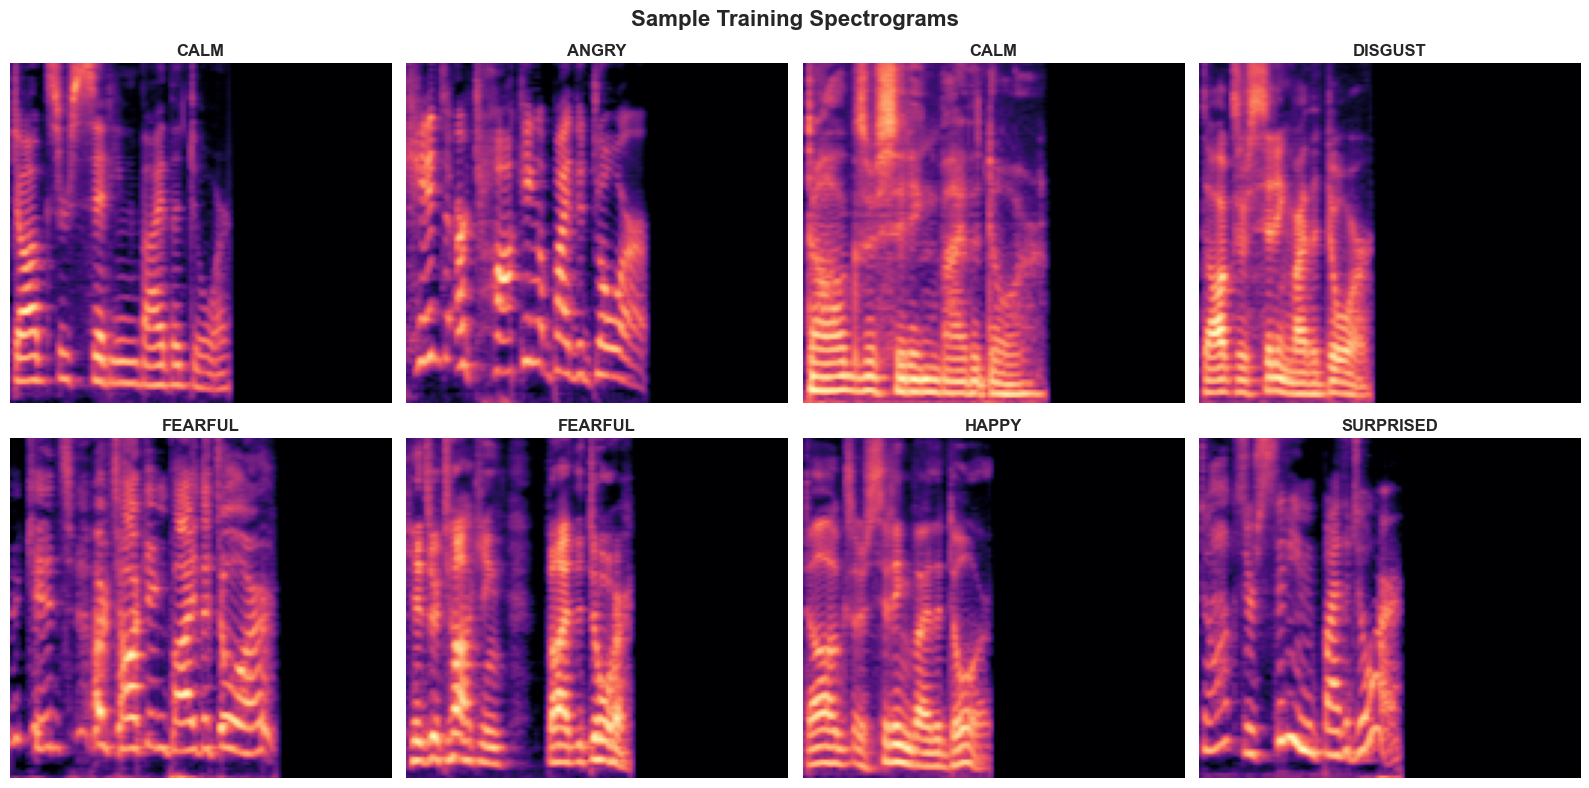

In [49]:
# Visualize sample spectrograms
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(8):
    idx = np.random.randint(0, len(X_train))
    spec = X_train[idx, :, :, 0]
    emotion_idx = np.argmax(y_train[idx])
    emotion = config.EMOTIONS[emotion_idx]
    
    axes[i].imshow(spec, aspect='auto', origin='lower', cmap='magma')
    axes[i].set_title(f'{emotion.upper()}', fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Sample Training Spectrograms', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Train the Model

In [61]:
# Get callbacks
callbacks = get_callbacks()

# Train model
print("Starting training...")
print(f"  Batch size: {config.BATCH_SIZE}")
print(f"  Epochs: {config.EPOCHS}")
print(f"  Learning rate: {config.LEARNING_RATE}\n")

history = model.fit(
    X_train, y_train,
    batch_size=config.BATCH_SIZE,
    epochs=config.EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\nTraining complete!")

Starting training...
  Batch size: 32
  Epochs: 100
  Learning rate: 0.001

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7813 - loss: 2.3441 - precision: 0.8716 - recall: 0.6220
Epoch 1: val_accuracy improved from -inf to 0.14583, saving model to C:\Users\manan_4lx8ye\Desktop\aiclubb\models\best_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - accuracy: 0.7807 - loss: 2.3444 - precision: 0.8713 - recall: 0.6218 - val_accuracy: 0.1458 - val_loss: 6.0736 - val_precision: 0.1397 - val_recall: 0.1319 - learning_rate: 1.2500e-04
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7681 - loss: 2.3081 - precision: 0.8787 - recall: 0.6456
Epoch 2: val_accuracy improved from 0.14583 to 0.21528, saving model to C:\Users\manan_4lx8ye\Desktop\aiclubb\models\best_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 240s 7s/step - accuracy: 0.7678 - loss: 2.3087 - precision: 0.8782 - recall: 0.6450 - val_accuracy: 0.2153 - val_loss: 5.2307 - val_precision: 0.2047 - val_recall: 

### Visualize Training History

Training curves saved to C:\Users\manan_4lx8ye\Desktop\aiclubb\results\plots\training_curves.png


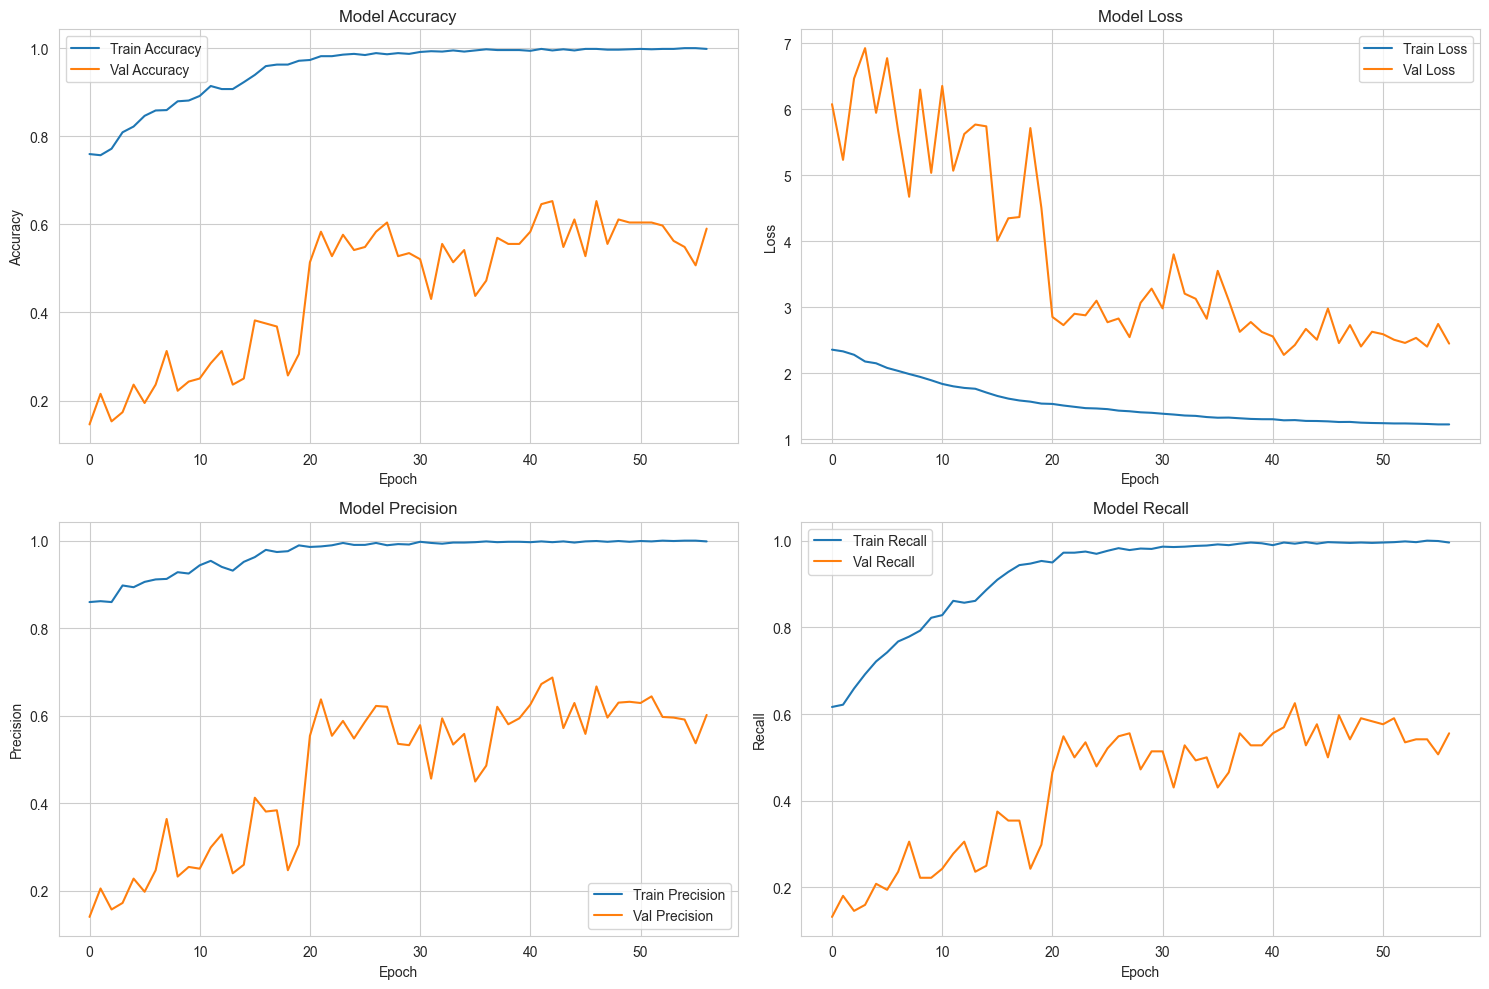

In [62]:
# Plot training curves
def plot_training_history(history, save_path=None):
    """
    Plot training and validation metrics
    
    Args:
        history: Keras training history object
        save_path: Path to save plot
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Val Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Precision
    if 'precision' in history.history:
        axes[1, 0].plot(history.history['precision'], label='Train Precision')
        axes[1, 0].plot(history.history['val_precision'], label='Val Precision')
        axes[1, 0].set_title('Model Precision')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True)
    
    # Recall
    if 'recall' in history.history:
        axes[1, 1].plot(history.history['recall'], label='Train Recall')
        axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
        axes[1, 1].set_title('Model Recall')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Training curves saved to {save_path}")
    
    plt.show()

plot_training_history(history, save_path=os.path.join(config.PLOTS_DIR, 'training_curves.png'))

---
## 8. Evaluation & Analysis

### Test Set Performance

In [63]:
# Evaluate on test set
test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)

# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate macro F1
macro_f1 = f1_score(y_test_classes, y_pred_classes, average='macro')

print("="*60)
print("TEST SET PERFORMANCE")
print("="*60)
print(f"  Test Accuracy:  {test_acc*100:.2f}%")
print(f"  Test Precision: {test_precision*100:.2f}%")
print(f"  Test Recall:    {test_recall*100:.2f}%")
print(f"  Macro F1-Score: {macro_f1*100:.2f}%")
print(f"  Test Loss:      {test_loss:.4f}")
print("="*60)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 607ms/step
TEST SET PERFORMANCE
  Test Accuracy:  64.58%
  Test Precision: 68.50%
  Test Recall:    60.42%
  Macro F1-Score: 63.96%
  Test Loss:      2.4924


### Classification Report

In [64]:
# Detailed classification report
print("\nCLASSIFICATION REPORT:")
print("="*60)
print(classification_report(y_test_classes, y_pred_classes, 
                          target_names=config.EMOTIONS,
                          digits=4))


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

     neutral     0.6250    1.0000    0.7692        10
        calm     0.7500    0.6316    0.6857        19
       happy     0.6000    0.4737    0.5294        19
         sad     0.5000    0.5789    0.5366        19
       angry     0.7647    0.6842    0.7222        19
     fearful     0.6842    0.6842    0.6842        19
     disgust     0.7500    0.3158    0.4444        19
   surprised     0.6129    0.9500    0.7451        20

    accuracy                         0.6458       144
   macro avg     0.6609    0.6648    0.6396       144
weighted avg     0.6628    0.6458    0.6322       144



### Confusion Matrix

Confusion matrix saved to C:\Users\manan_4lx8ye\Desktop\aiclubb\results\plots\confusion_matrix.png


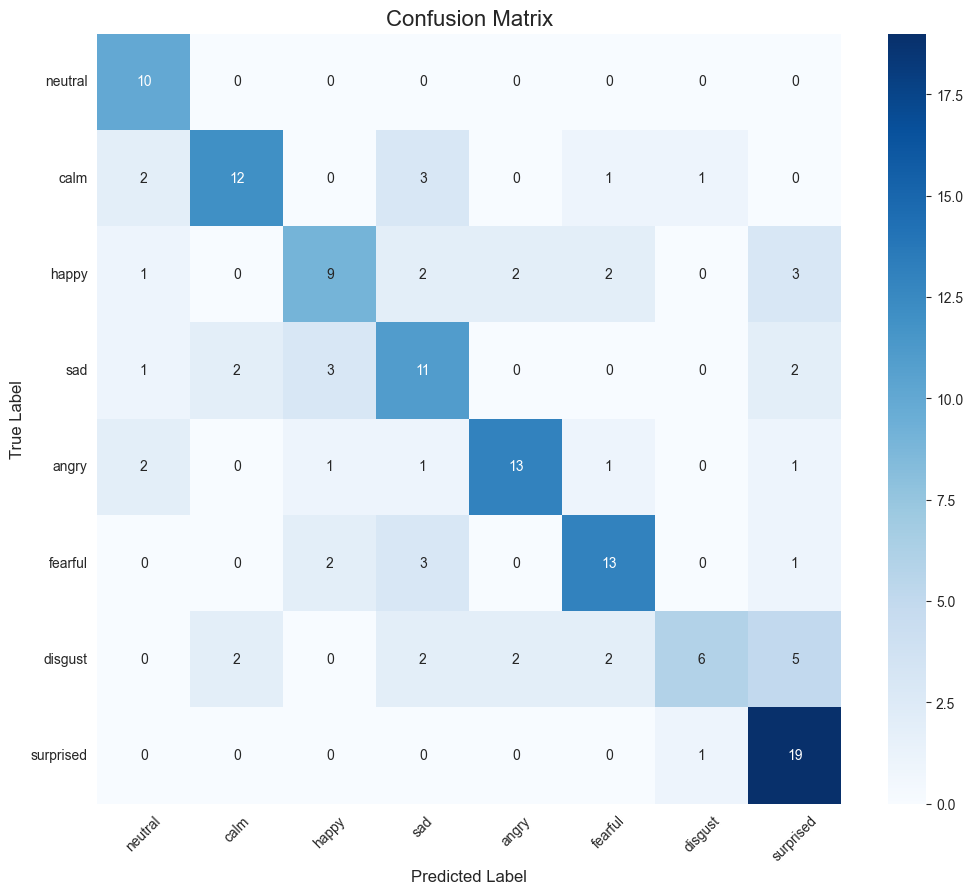

In [65]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, 
                     save_path=os.path.join(config.PLOTS_DIR, 'confusion_matrix.png'))

### Gender Bias Analysis

In [66]:
# Analyze performance by gender (requires gender labels for test set)
# This is a simplified example - you'd need to track gender through the pipeline

print("Gender Bias Analysis:")
print("="*60)
print("Note: This analysis requires gender metadata for test samples.")
print("Implement gender tracking in load_dataset() for detailed analysis.")
print("="*60)

# TODO: Implement gender-specific accuracy calculation
# male_accuracy = ...
# female_accuracy = ...
# print(f"Male speakers accuracy: {male_accuracy:.2%}")
# print(f"Female speakers accuracy: {female_accuracy:.2%}")

Gender Bias Analysis:
Note: This analysis requires gender metadata for test samples.
Implement gender tracking in load_dataset() for detailed analysis.


### Per-Class Performance


Per-Class Performance:
  Emotion  Precision   Recall  F1-Score
  neutral   0.625000 1.000000  0.769231
surprised   0.612903 0.950000  0.745098
    angry   0.764706 0.684211  0.722222
     calm   0.750000 0.631579  0.685714
  fearful   0.684211 0.684211  0.684211
      sad   0.500000 0.578947  0.536585
    happy   0.600000 0.473684  0.529412
  disgust   0.750000 0.315789  0.444444


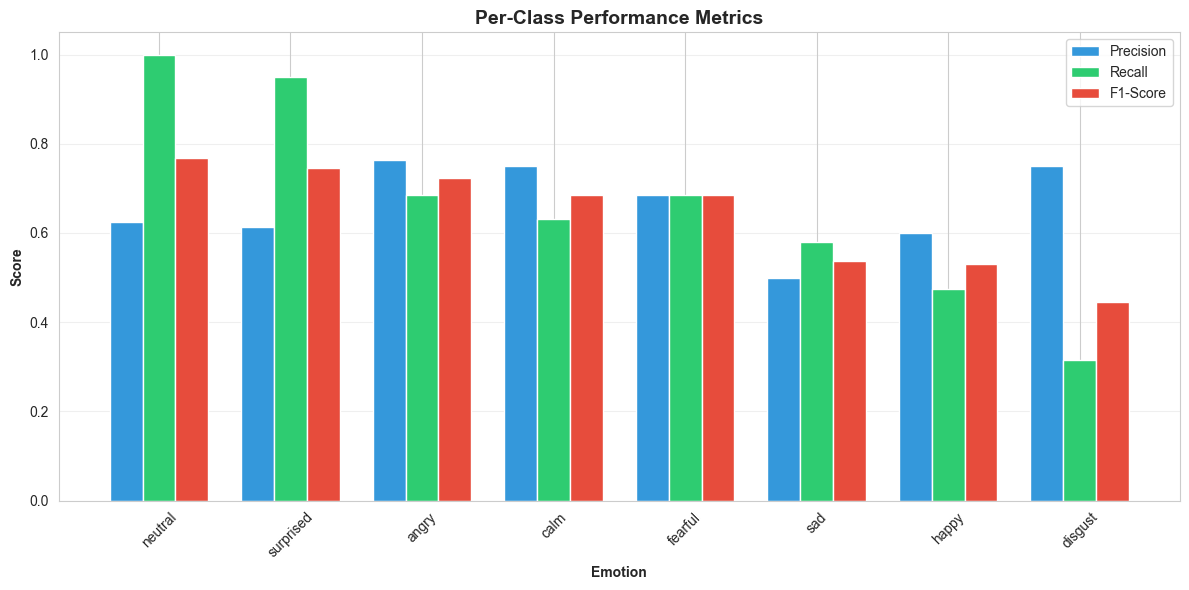

In [67]:
# Calculate per-class metrics
from sklearn.metrics import precision_score, recall_score, f1_score

per_class_precision = precision_score(y_test_classes, y_pred_classes, average=None)
per_class_recall = recall_score(y_test_classes, y_pred_classes, average=None)
per_class_f1 = f1_score(y_test_classes, y_pred_classes, average=None)

# Create DataFrame
metrics_df = pd.DataFrame({
    'Emotion': config.EMOTIONS,
    'Precision': per_class_precision,
    'Recall': per_class_recall,
    'F1-Score': per_class_f1
})

metrics_df = metrics_df.sort_values('F1-Score', ascending=False)
print("\nPer-Class Performance:")
print(metrics_df.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(config.EMOTIONS))
width = 0.25

ax.bar(x - width, metrics_df['Precision'], width, label='Precision', color='#3498db')
ax.bar(x, metrics_df['Recall'], width, label='Recall', color='#2ecc71')
ax.bar(x + width, metrics_df['F1-Score'], width, label='F1-Score', color='#e74c3c')

ax.set_xlabel('Emotion', fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df['Emotion'], rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Prediction Examples

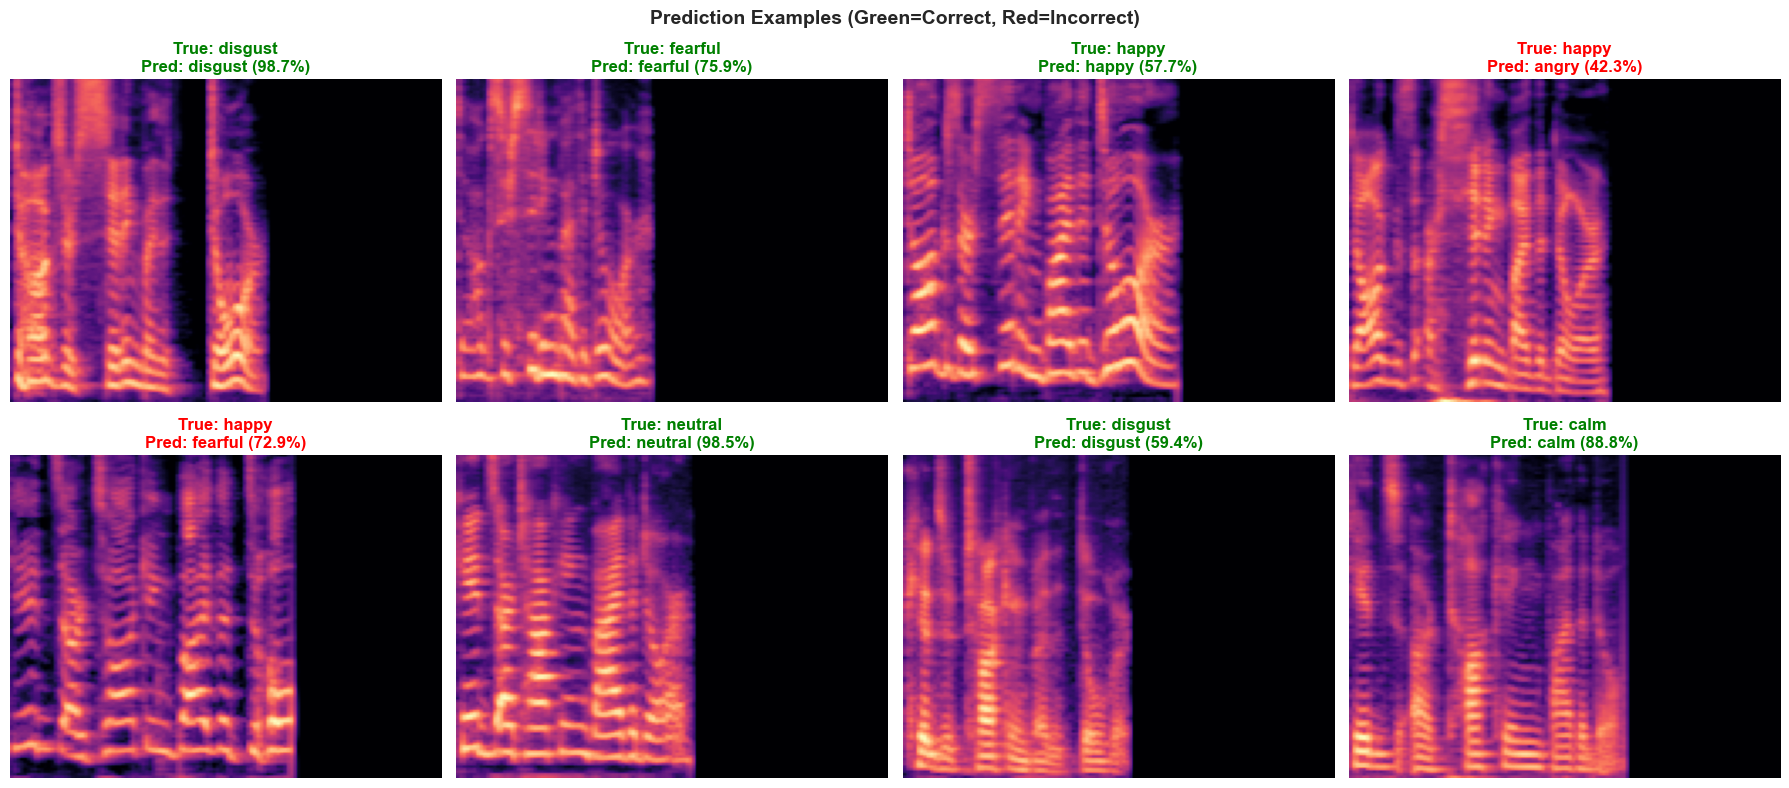

In [68]:
# Show some prediction examples
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for i in range(8):
    idx = np.random.randint(0, len(X_test))
    
    # Get prediction
    pred_probs = y_pred[idx]
    pred_class = np.argmax(pred_probs)
    true_class = y_test_classes[idx]
    
    pred_emotion = config.EMOTIONS[pred_class]
    true_emotion = config.EMOTIONS[true_class]
    confidence = pred_probs[pred_class] * 100
    
    # Plot spectrogram
    spec = X_test[idx, :, :, 0]
    axes[i].imshow(spec, aspect='auto', origin='lower', cmap='magma')
    
    # Set title with color based on correctness
    color = 'green' if pred_class == true_class else 'red'
    title = f'True: {true_emotion}\nPred: {pred_emotion} ({confidence:.1f}%)'
    axes[i].set_title(title, fontweight='bold', color=color)
    axes[i].axis('off')

plt.suptitle('Prediction Examples (Green=Correct, Red=Incorrect)', 
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 9. Conclusion

### Key Findings

1. **Model Performance**: The CNN successfully learns to classify emotions from audio spectrograms
2. **Challenging Classes**: Some emotions (e.g., Calm vs. Neutral) are harder to distinguish
3. **Data Augmentation**: Critical for preventing overfitting on small datasets
4. **Spectral Patterns**: High-arousal emotions show distinct spectral energy patterns

### Future Improvements

1. **More Data Augmentation**: Experiment with additional augmentation techniques
2. **Ensemble Methods**: Combine multiple models for better performance
3. **Transfer Learning**: Use pre-trained models from ImageNet
4. **Attention Mechanisms**: Add attention layers to focus on important time frames
5. **Multi-Modal**: Combine audio with text transcripts

### Deliverables Checklist

- ✅ Notebook with EDA, training, and evaluation
- ✅ Model weights (.h5 file)
- ✅ predict.py for live inference
- ✅ Confusion matrix and metrics
- ✅ Macro F1-Score analysis

---

**Task Completed!** 🎉

In [70]:
# Save final metrics
final_metrics = {
    'test_accuracy': float(test_acc),
    'test_precision': float(test_precision),
    'test_recall': float(test_recall),
    'macro_f1_score': float(macro_f1),
    'test_loss': float(test_loss),
    'per_class_metrics': metrics_df.to_dict('records')
}

import json
with open(os.path.join(config.RESULTS_DIR, 'metrics.json'), 'w') as f:
    json.dump(final_metrics, f, indent=4)

print("Metrics saved to results/metrics.json")

Metrics saved to results/metrics.json
